# Evolution of urban patterns: urban morphology as an open reproducible data science

## Summary statistics

This is the second notebook in a sequence of three. The notebook summarise morphometric data obtained in the previous notebook on the basis of historical periods.

It requires `data/case_studies.csv` input with origins of case studies and data generated by the first notebook.

Date: May 17, 2021

---

We start with the import of libraries used in this notebook.

In [1]:
import pandas as pd
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import glob
import pathlib
from palettable.wesanderson import Moonrise5_6

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-x7v3hb4j because the default path (/home/jovyan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Using seaborn we can specify global settings for all matplotlib-based plots.

In [2]:
sns.set()

We will need the original input of our case studies as we needed in the first notebook.

In [3]:
cases = pd.read_csv("data/case_studies.csv")
cases

case           period  \
0                 Athens   pre-industrial   
1                 Brugge   pre-industrial   
2                 Havana   pre-industrial   
3                  Kyoto   pre-industrial   
4              Nuremberg   pre-industrial   
5                  Pavia   pre-industrial   
6                 Recife   pre-industrial   
7              Barcelona       industrial   
8               Brisbane       industrial   
9           Buenos Aires       industrial   
10               Chicago       industrial   
11               De Pijp       industrial   
12                 Paris       industrial   
13          Philadelphia       industrial   
14         Akademgorodok        modernist   
15              Brasilia        modernist   
16        Drumul Taberei        modernist   
17               Kilamba        modernist   
18               Marzhan        modernist   
19                Tblisi        modernist   
20               Karvina        modernist   
21        Ciudad Guayana      garden city   
22               Frohnau      garden city   
23             Hilversum      garden city   
24              Montreal      garden city   
25            Greenhills      garden city   
26              Stratton      garden city   
27              Tel Aviv      garden city   
28              Auckland  neo-traditional   
29           Brandevoort  neo-traditional   
30       Cornell Village  neo-traditional   
31             Kentlands  neo-traditional   
32               Mueller  neo-traditional   
33           Miami Lakes  neo-traditional   
34           Rieselfield  neo-traditional   
35        Abdurahmangazi         informal   
36         Bicentennaire         informal   
37  Jardim Portal I e II         informal   
38                Kricak         informal   
39              Mafalala         informal   
40               Tandale         informal   
41                 Tondo         informal   

                                       origin  
0    (23.729297894645065, 37.977742321097296)  
1      (3.222135599564842, 51.20663413385126)  
2    (-82.35387869733259, 23.137058811383366)  
3     (135.77513789847612, 35.00441991880096)  
4      (11.080741895925831, 49.4558122318182)  
5      (9.155202505665285, 45.18542787308676)  
6    (-34.87950134898907, -8.066819977715335)  
7     (2.1599658311051333, 41.39207228345335)  
8   (153.00890689998246, -27.483072513877765)  
9   (-58.37436109734774, -34.618526518125655)  
10     (-87.6496541987247, 41.91601382423912)  
11                      (4.890787, 52.353532)  
12    (2.3036982060349636, 48.86864235146261)  
13    (-75.17713599972483, 39.92784202217783)  
14     (83.10742859587872, 54.83929583879922)  
15  (-47.91657209425542, -15.823763507567802)  
16     (26.02122171749766, 44.41721907853648)  
17   (13.273496897999385, -8.998426816984628)  
18    (13.558283202822224, 52.55398573559633)  
19     (44.72275760065603, 41.72302532410621)  
20                     (18.557418, 49.853861)  
21     (-62.67209868783639, 8.34826427219966)  
22   (13.277062904022877, 52.631536235815815)  
23     (5.170650196333054, 52.23187803549469)  
24   (-73.64192800272671, 45.522340227287295)  
25                    (-87.996019, 42.941374)  
26  (116.04114530164892, -31.864639316563675)  
27     (34.977140396112986, 32.0925043168361)  
28    (174.9160552559242, -36.95408615897924)  
29      (5.62261399486988, 51.46170483425585)  
30    (-79.23037000333382, 43.88964002638408)  
31   (-77.24424129756238, 39.120324272641994)  
32   (-97.70314980255172, 30.292836815637383)  
33                     (-80.31195, 25.905058)  
34     (7.792109457726385, 47.99888843253804)  
35     (29.25333679557981, 40.96419132348267)  
36   (-72.35389200521153, 18.535389208950473)  
37  (-46.57587250888991, -23.440949292392443)  
38   (110.35677760126997, -7.773518503607216)  
39  (32.572846900841455, -25.952561712972226)  
40    (39.24312098621779, -6.792734470840269)  
41    (120.9641471044341, 14.616058307179102)

It will be easier to use `case` column as an index.

In [4]:
cases = cases.set_index("case")

Using `glob` library, we get a list of all GeoPackages created in the first notebook.

In [5]:
files = glob.glob("data/*gpkg")

We need to generate a single DataFrame with all the results of all case studies combined. Let's prepare an empty DataFrame for that.

In [6]:
data = pd.DataFrame()

Now we loop through the list of GeoPackages and:
1. Read the file.
2. Select only those geometries within 400 m buffer around the origin. That way we minimise potential edge effect affecting the results.
3. Store period and case name within the DataFrame and append it together with morphometric data from GPKG to our `data` DataFrame.

In [7]:
for f in files:
    tessellation = gpd.read_file(f, layer="tessellation")
    case = pathlib.Path(f).stem
    coords = cases.origin.loc[case]
    buffer = gpd.GeoSeries([Point(tuple(map(float, coords[1:-1].split(', '))))], crs=4326).to_crs(tessellation.crs).buffer(400)
    tessellation['period'] = cases.period.loc[case]
    tessellation['case'] = case
    casegdf = tessellation[tessellation.centroid.within(buffer.iloc[0])]
    data = data.append(casegdf.drop(columns=["uID", "nID", "mm_len", "node_start", "node_end", "nodeID", "geometry"]))

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Since `period` is an ordered categorical column, let's encode it as such.

In [8]:
data['period'] = pd.Categorical(data['period'], categories=['pre-industrial', 'industrial', 'garden city', 'modernist', 'neo-traditional', 'informal'], ordered=True)

Now we can sort the `data` based on the `period` in a way which follows the time.

In [9]:
data = data.sort_values('period').reset_index(drop=True)

For our figures, we want `paper` context, `whitegrid` style and `palettable`'s `Moonrise5_6` color palette.

In [10]:
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette(Moonrise5_6.hex_colors)

It is better to rename final labels to nicers ones, so let's prepare a dictionary for that.

In [11]:
labels = {
    "cell_area": "Area of a tessellation cell [m]",
    "car": "Covered area ratio",
    "blg_area": "Area of a building footprint [m]",
    "wall": "Length of a perimeter wall [m]",
    "adjacency": "Building adjacency",
    "neighbour_distance": "Mean neighbor distance between buildings [m]",
    "length": "Length of a street segment [m]",
    "linearity": "Linearity of a street segment",
    "width": "Width of a street profile [m]",
    "width_deviation": "Width deviation of a street profile [m]",
    "openness": "Openness of a street profile",
    "meshedness": "Meshedness of a street network",
}

Now we loop through all morphometric characters and create box plots for each city, once with normal y axis and once with log y axis.

In [12]:
for ch in data.columns.drop(['case', 'period']):
    plt.figure(figsize=(12, 8))
    boxen = sns.boxplot(x="case", y=ch, hue='period', dodge=False, data=data, showfliers=False)
    boxen.set_xticklabels(boxen.get_xticklabels(), rotation=90)
    boxen.set_ylabel(labels[ch])
    boxen.set_xlabel("Case study")
    sns.despine()
    plt.legend(loc="lower left", borderaxespad=0., ncol=6, frameon=False)
    plt.savefig(f"figures/{ch}_all_normal.png", bbox_inches="tight")
    plt.close("all")
    
    plt.figure(figsize=(12, 8))
    boxen = sns.boxplot(x="case", y=ch, hue='period', dodge=False, data=data, showfliers=False)
    boxen.set_xticklabels(boxen.get_xticklabels(), rotation=90)
    boxen.set_ylabel(labels[ch])
    boxen.set_xlabel("Case study")
    boxen.set_yscale("log")
    sns.despine()
    plt.legend(loc="lower left", borderaxespad=0., ncol=6, frameon=False)
    plt.savefig(f"figures/{ch}_all_log.png", bbox_inches="tight")
    plt.close("all")

We can also create box plots for each character grouped by period.

In [13]:
for ch in data.columns.drop(['case', 'period']):
    plt.figure(figsize=(12, 8))
    box = sns.boxplot(x="period", y=ch,dodge=False, data=data, showfliers=False)
    box.set_ylabel(labels[ch])
    box.set_xlabel("Historical period")
    sns.despine()
    plt.savefig(f"figures/{ch}_grouped_normal.png", bbox_inches="tight")
    plt.close("all")
    
    plt.figure(figsize=(12, 8))
    box = sns.boxplot(x="period", y=ch,dodge=False, data=data, showfliers=False)
    box.set_ylabel(labels[ch])
    box.set_xlabel("Historical period")
    box.set_yscale("log")
    sns.despine()
    plt.savefig(f"figures/{ch}_grouped_log.png", bbox_inches="tight")
    plt.close("all")

To report median values per character and period, we can create a grouped DataFrame.

In [16]:
grouper = data.drop(columns='case').groupby('period')
medians = grouper.median()
medians = medians.rename(columns=labels)
med = medians.T.round(2)
med

period                                        pre-industrial  industrial  \
Area of a tessellation cell [m]                       177.03      171.40   
Covered area ratio                                      0.62        0.53   
Area of a building footprint [m]                       98.74       80.32   
Length of a perimeter wall [m]                        282.85      335.94   
Building adjacency                                      0.20        0.20   
Mean neighbor distance between buildings [m]            3.44        6.56   
Length of a street segment [m]                         91.81      136.51   
Linearity of a street segment                           1.00        1.00   
Width of a street profile [m]                          10.16       15.16   
Width deviation of a street profile [m]                 3.16        2.31   
Openness of a street profile                            0.15        0.18   
Meshedness of a street network                          0.17        0.26   

period                                        garden city  modernist  \
Area of a tessellation cell [m]                    589.16    3377.37   
Covered area ratio                                   0.22       0.16   
Area of a building footprint [m]                   141.49     545.36   
Length of a perimeter wall [m]                      60.26     169.43   
Building adjacency                                   0.84       0.92   
Mean neighbor distance between buildings [m]        14.67      32.56   
Length of a street segment [m]                     154.63     196.23   
Linearity of a street segment                        1.00       1.00   
Width of a street profile [m]                       29.12      33.25   
Width deviation of a street profile [m]              3.59       3.30   
Openness of a street profile                         0.38       0.61   
Meshedness of a street network                       0.15       0.14   

period                                        neo-traditional  informal  
Area of a tessellation cell [m]                        504.60    109.79  
Covered area ratio                                       0.27      0.51  
Area of a building footprint [m]                       143.27     52.87  
Length of a perimeter wall [m]                          68.33     32.48  
Building adjacency                                       1.00      1.00  
Mean neighbor distance between buildings [m]            12.94      3.00  
Length of a street segment [m]                         131.60    133.96  
Linearity of a street segment                            1.00      0.99  
Width of a street profile [m]                           24.70     12.44  
Width deviation of a street profile [m]                  2.87      4.75  
Openness of a street profile                             0.35      0.13  
Meshedness of a street network                           0.20      0.12

It may also be useful to report interquartile range to illustrate the spread of each distribution.

In [17]:
iqr = (grouper.quantile(.75).values - grouper.quantile(.25))
iqr = iqr.rename(columns=labels)
iq = iqr.T.round(2)
iq

period                                        pre-industrial  industrial  \
Area of a tessellation cell [m]                       262.39      276.77   
Covered area ratio                                      0.28        0.20   
Area of a building footprint [m]                      136.78      113.72   
Length of a perimeter wall [m]                        351.53      399.06   
Building adjacency                                      0.29        0.20   
Mean neighbor distance between buildings [m]            3.57        4.40   
Length of a street segment [m]                         71.42       51.10   
Linearity of a street segment                           0.01        0.00   
Width of a street profile [m]                           5.81       10.96   
Width deviation of a street profile [m]                 2.44        1.88   
Openness of a street profile                            0.13        0.13   
Meshedness of a street network                          0.07        0.05   

period                                        garden city  modernist  \
Area of a tessellation cell [m]                    642.93    3742.74   
Covered area ratio                                   0.15       0.10   
Area of a building footprint [m]                   136.75     592.86   
Length of a perimeter wall [m]                      42.09     101.07   
Building adjacency                                   0.34       0.42   
Mean neighbor distance between buildings [m]        10.45      19.40   
Length of a street segment [m]                     121.79     169.47   
Linearity of a street segment                        0.04       0.17   
Width of a street profile [m]                        6.93      13.07   
Width deviation of a street profile [m]              1.88       2.82   
Openness of a street profile                         0.23       0.22   
Meshedness of a street network                       0.09       0.05   

period                                        neo-traditional  informal  
Area of a tessellation cell [m]                        639.15    122.36  
Covered area ratio                                       0.17      0.27  
Area of a building footprint [m]                       137.69     56.23  
Length of a perimeter wall [m]                          39.54     22.24  
Building adjacency                                       0.44      0.05  
Mean neighbor distance between buildings [m]             9.54      3.32  
Length of a street segment [m]                         100.27    124.83  
Linearity of a street segment                            0.03      0.06  
Width of a street profile [m]                            9.86      6.86  
Width deviation of a street profile [m]                  1.99      1.74  
Openness of a street profile                             0.23      0.14  
Meshedness of a street network                           0.06      0.08

We want to report both in the same table.

In [20]:
med.astype('str') + ' (' + iq.astype('str') + ')'

period                                         pre-industrial  \
Area of a tessellation cell [m]               177.03 (262.39)   
Covered area ratio                                0.62 (0.28)   
Area of a building footprint [m]               98.74 (136.78)   
Length of a perimeter wall [m]                282.85 (351.53)   
Building adjacency                                 0.2 (0.29)   
Mean neighbor distance between buildings [m]      3.44 (3.57)   
Length of a street segment [m]                  91.81 (71.42)   
Linearity of a street segment                      1.0 (0.01)   
Width of a street profile [m]                    10.16 (5.81)   
Width deviation of a street profile [m]           3.16 (2.44)   
Openness of a street profile                      0.15 (0.13)   
Meshedness of a street network                    0.17 (0.07)   

period                                             industrial  \
Area of a tessellation cell [m]                171.4 (276.77)   
Covered area ratio                                 0.53 (0.2)   
Area of a building footprint [m]               80.32 (113.72)   
Length of a perimeter wall [m]                335.94 (399.06)   
Building adjacency                                  0.2 (0.2)   
Mean neighbor distance between buildings [m]       6.56 (4.4)   
Length of a street segment [m]                  136.51 (51.1)   
Linearity of a street segment                       1.0 (0.0)   
Width of a street profile [m]                   15.16 (10.96)   
Width deviation of a street profile [m]           2.31 (1.88)   
Openness of a street profile                      0.18 (0.13)   
Meshedness of a street network                    0.26 (0.05)   

period                                            garden city  \
Area of a tessellation cell [m]               589.16 (642.93)   
Covered area ratio                                0.22 (0.15)   
Area of a building footprint [m]              141.49 (136.75)   
Length of a perimeter wall [m]                  60.26 (42.09)   
Building adjacency                                0.84 (0.34)   
Mean neighbor distance between buildings [m]    14.67 (10.45)   
Length of a street segment [m]                154.63 (121.79)   
Linearity of a street segment                      1.0 (0.04)   
Width of a street profile [m]                    29.12 (6.93)   
Width deviation of a street profile [m]           3.59 (1.88)   
Openness of a street profile                      0.38 (0.23)   
Meshedness of a street network                    0.15 (0.09)   

period                                                modernist  \
Area of a tessellation cell [m]               3377.37 (3742.74)   
Covered area ratio                                   0.16 (0.1)   
Area of a building footprint [m]                545.36 (592.86)   
Length of a perimeter wall [m]                  169.43 (101.07)   
Building adjacency                                  0.92 (0.42)   
Mean neighbor distance between buildings [m]       32.56 (19.4)   
Length of a street segment [m]                  196.23 (169.47)   
Linearity of a street segment                        1.0 (0.17)   
Width of a street profile [m]                     33.25 (13.07)   
Width deviation of a street profile [m]              3.3 (2.82)   
Openness of a street profile                        0.61 (0.22)   
Meshedness of a street network                      0.14 (0.05)   

period                                        neo-traditional         informal  
Area of a tessellation cell [m]                504.6 (639.15)  109.79 (122.36)  
Covered area ratio                                0.27 (0.17)      0.51 (0.27)  
Area of a building footprint [m]              143.27 (137.69)    52.87 (56.23)  
Length of a perimeter wall [m]                  68.33 (39.54)    32.48 (22.24)  
Building adjacency                                 1.0 (0.44)       1.0 (0.05)  
Mean neighbor distance between buildings [m]     12.94 (9.54)       3.0 (3.32)  
Length of a street segm

Following cells pick individual boxplots (same we created above) and generate combined figures used in the final paper.

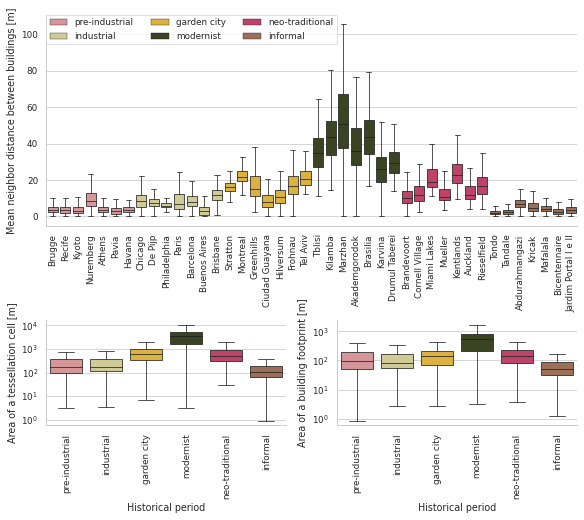

In [67]:
fig = plt.figure(figsize=(8, 7), constrained_layout=True)
gs = fig.add_gridspec(6, 2)
top = fig.add_subplot(gs[0:4, :])
left = fig.add_subplot(gs[4:, 0])
right = fig.add_subplot(gs[4:, 1])

sns.boxplot(x="case", y='neighbour_distance', hue='period', dodge=False, data=data, showfliers=False, ax=top, linewidth=.75)
top.set_xticklabels(top.get_xticklabels(), rotation=90)
top.set_ylabel(labels['neighbour_distance'])
top.set_xlabel("")

sns.boxplot(x="period", y='cell_area',dodge=False, data=data, showfliers=False, ax=left, linewidth=.75)
left.set_ylabel(labels['cell_area'])
left.set_xlabel("Historical period")
left.set_xticklabels(left.get_xticklabels(), rotation=90)
left.set_yscale("log")

sns.boxplot(x="period", y='blg_area',dodge=False, data=data, showfliers=False, ax=right, linewidth=.75)
right.set_ylabel(labels['blg_area'])
right.set_xlabel("Historical period")
right.set_xticklabels(right.get_xticklabels(), rotation=90)
right.set_yscale("log")
sns.despine()

top.legend(loc="upper left", borderaxespad=0., ncol=3, frameon=True)
plt.savefig(f"figures/results_1.png", bbox_inches="tight", dpi=300)

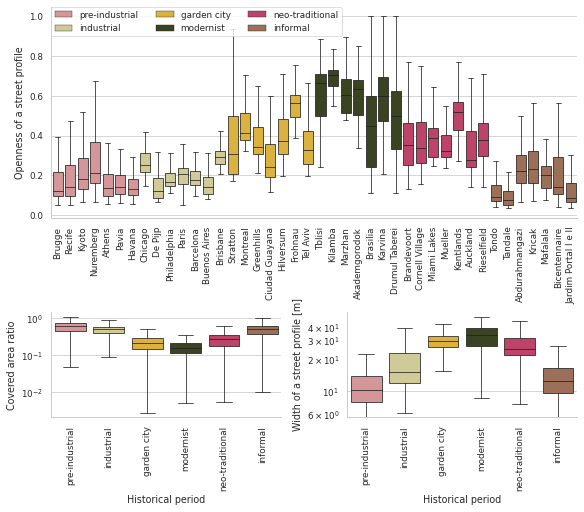

In [66]:
fig = plt.figure(figsize=(8, 7), constrained_layout=True)
gs = fig.add_gridspec(6, 2)
top = fig.add_subplot(gs[0:4, :])
left = fig.add_subplot(gs[4:, 0])
right = fig.add_subplot(gs[4:, 1])

sns.boxplot(x="case", y='openness', hue='period', dodge=False, data=data, showfliers=False, ax=top, linewidth=.75)
top.set_xticklabels(top.get_xticklabels(), rotation=90)
top.set_ylabel(labels['openness'])
top.set_xlabel("")

sns.boxplot(x="period", y='car',dodge=False, data=data, showfliers=False, ax=left, linewidth=.75)
left.set_ylabel(labels['car'])
left.set_xlabel("Historical period")
left.set_xticklabels(left.get_xticklabels(), rotation=90)
left.set_yscale("log")

sns.boxplot(x="period", y='width',dodge=False, data=data, showfliers=False, ax=right, linewidth=.75)
right.set_ylabel(labels['width'])
right.set_xlabel("Historical period")
right.set_xticklabels(right.get_xticklabels(), rotation=90)
right.set_yscale("log")
sns.despine()

top.legend(loc="upper left", borderaxespad=0., ncol=3, frameon=True)
plt.savefig(f"figures/results_2.png", bbox_inches="tight", dpi=300)

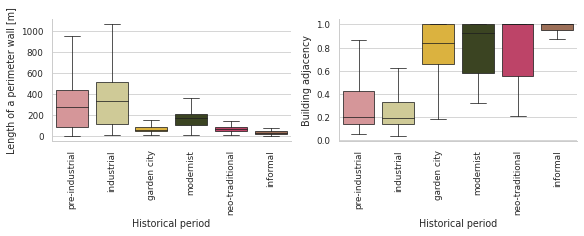

In [72]:
fig = plt.figure(figsize=(8, 3), constrained_layout=True)
gs = fig.add_gridspec(1, 2)
left = fig.add_subplot(gs[0, 0])
right = fig.add_subplot(gs[0, 1])

sns.boxplot(x="period", y='wall',dodge=False, data=data, showfliers=False, ax=left, linewidth=.75)
left.set_ylabel(labels['wall'])
left.set_xlabel("Historical period")
left.set_xticklabels(left.get_xticklabels(), rotation=90)

sns.boxplot(x="period", y='adjacency',dodge=False, data=data, showfliers=False, ax=right, linewidth=.75)
right.set_ylabel(labels['adjacency'])
right.set_xlabel("Historical period")
right.set_xticklabels(right.get_xticklabels(), rotation=90)
sns.despine()

plt.savefig(f"figures/results_3.png", bbox_inches="tight", dpi=300)

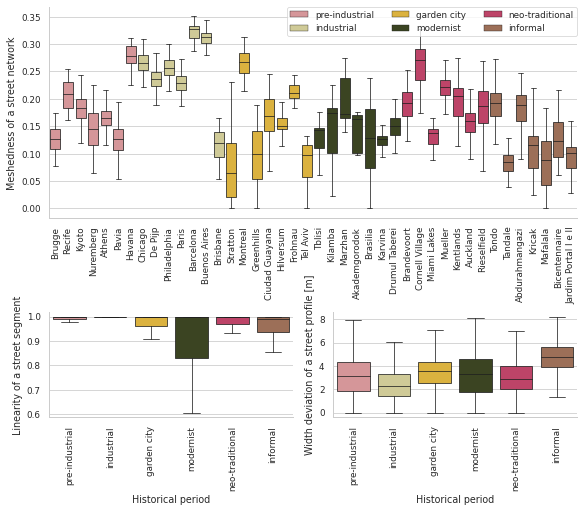

In [75]:
fig = plt.figure(figsize=(8, 7), constrained_layout=True)
gs = fig.add_gridspec(6, 2)
top = fig.add_subplot(gs[0:4, :])
left = fig.add_subplot(gs[4:, 0])
right = fig.add_subplot(gs[4:, 1])

sns.boxplot(x="case", y='meshedness', hue='period', dodge=False, data=data, showfliers=False, ax=top, linewidth=.75)
top.set_xticklabels(top.get_xticklabels(), rotation=90)
top.set_ylabel(labels['meshedness'])
top.set_xlabel("")

sns.boxplot(x="period", y='linearity',dodge=False, data=data, showfliers=False, ax=left, linewidth=.75)
left.set_ylabel(labels['linearity'])
left.set_xlabel("Historical period")
left.set_xticklabels(left.get_xticklabels(), rotation=90)

sns.boxplot(x="period", y='width_deviation',dodge=False, data=data, showfliers=False, ax=right, linewidth=.75)
right.set_ylabel(labels['width_deviation'])
right.set_xlabel("Historical period")
right.set_xticklabels(right.get_xticklabels(), rotation=90)
sns.despine()

top.legend(loc="upper right", borderaxespad=0., ncol=3, frameon=True)
plt.savefig(f"figures/results_4.png", bbox_inches="tight", dpi=300)

## Statistical comparison

We also want to compare similarity of distributions statistically, not only visually. We use Kruskal–Wallis one-way analysis of variance and Pairwise Mann–Whitney *U* test for that.

In [10]:
from scipy import stats

data = data.set_index('case')

In [13]:
data = data.rename(columns=labels)

### Kruskal–Wallis one-way analysis of variance

Kruskal–Wallis one-way analysis of variance is chosen as a non-parametric equivalent of ANOVA due to skewed distributions of underlying data.

In [14]:
kruskal = pd.DataFrame()
for col in data.columns.drop("period"):
    H, p = stats.kruskal(*[data[data.period == per][col] for per in data.period.cat.categories])
    kruskal.loc[col, 'H'] = H
    kruskal.loc[col, 'p'] = p

In [15]:
kruskal

H    p
Area of a tessellation cell [m]               16091.729256  0.0
Covered area ratio                            14840.457954  0.0
Area of a building footprint [m]              10044.313353  0.0
Length of a perimeter wall [m]                20996.802901  0.0
Building adjacency                            25942.003837  0.0
Mean neighbor distance between buildings [m]  21449.270408  0.0
Length of a street segment [m]                 2870.986793  0.0
Linearity of a street segment                 10832.608655  0.0
Width of a street profile [m]                 20907.856962  0.0
Width deviation of a street profile [m]       17022.101966  0.0
Openness of a street profile                  15489.762454  0.0
Meshedness of a street network                22363.576671  0.0

The results indicate that the distributions of morphometric values obtained from samples from different historical periods cannot be considered the same.

### Pairwise Mann–Whitney _U_ test

In [26]:
from itertools import product

mann_whitney_U = {}
mann_whitney_p = {}
for col in data.columns.drop("period"):
    df_u = pd.DataFrame(columns=data.period.cat.categories, index=data.period.cat.categories)
    df_p = pd.DataFrame(columns=data.period.cat.categories, index=data.period.cat.categories)
    for a, b in product(data.period.cat.categories, repeat=2):
        if pd.isna(df_u.loc[b, a]):
            U, p = stats.mannwhitneyu(data[data.period == a][col], data[data.period == b][col])
            df_u.loc[a, b] = U
            df_p.loc[a, b] = p
        else:
            df_u.loc[a, b] = df_u.loc[b, a]
            df_p.loc[a, b] = df_p.loc[b, a]
            
    mann_whitney_U[col] = df_u
    mann_whitney_p[col] = df_p

In [27]:
for col in data.columns.drop("period"):
    if not (mann_whitney_p[col] > .05).sum().sum() == 6:
        print(f"{col}")

Building adjacency
Linearity of a street segment
Width deviation of a street profile [m]


In three cases, `Building adjacency`, `Linearity of a street segment`, and `Width deviation of a street profile`, Mann–Whitney _U_ is not significant (`p < 0.05`) in all pairwise cases.

In [28]:
mann_whitney_p['Building adjacency'] > .05

pre-industrial  industrial  garden city  modernist  \
pre-industrial             True       False        False      False   
industrial                False        True        False      False   
garden city               False       False         True       True   
modernist                 False       False         True       True   
neo-traditional           False       False        False      False   
informal                  False       False        False      False   

                 neo-traditional  informal  
pre-industrial             False     False  
industrial                 False     False  
garden city                False     False  
modernist                  False     False  
neo-traditional             True     False  
informal                   False      True

In [31]:
mann_whitney_p['Building adjacency'].round(3)

pre-industrial industrial garden city modernist  \
pre-industrial             0.5        0.0         0.0       0.0   
industrial                 0.0        0.5         0.0       0.0   
garden city                0.0        0.0    0.499998  0.404944   
modernist                  0.0        0.0    0.404944  0.499981   
neo-traditional            0.0        0.0         0.0       0.0   
informal                   0.0        0.0         0.0       0.0   

                neo-traditional informal  
pre-industrial              0.0      0.0  
industrial                  0.0      0.0  
garden city                 0.0      0.0  
modernist                   0.0      0.0  
neo-traditional        0.499998      0.0  
informal                    0.0      0.5

In the case of `Building adjacency`, the distributions of values in Garden city and Modernist periods cannot be considered significantly different. 

In [21]:
mann_whitney_p['Linearity of a street segment'] > .05

pre-industrial  industrial  garden city  modernist  \
pre-industrial             True       False        False      False   
industrial                False        True        False      False   
garden city               False       False         True       True   
modernist                 False       False         True       True   
neo-traditional           False       False        False      False   
informal                  False       False        False      False   

                 neo-traditional  informal  
pre-industrial             False     False  
industrial                 False     False  
garden city                False     False  
modernist                  False     False  
neo-traditional             True     False  
informal                   False      True

In [32]:
mann_whitney_p['Linearity of a street segment'].round(3)

pre-industrial industrial garden city modernist  \
pre-industrial             0.5        0.0         0.0       0.0   
industrial                 0.0        0.5         0.0       0.0   
garden city                0.0        0.0    0.499998  0.153011   
modernist                  0.0        0.0    0.153011  0.499981   
neo-traditional            0.0        0.0         0.0  0.000139   
informal                   0.0        0.0         0.0  0.000064   

                neo-traditional  informal  
pre-industrial              0.0       0.0  
industrial                  0.0       0.0  
garden city                 0.0       0.0  
modernist              0.000139  0.000064  
neo-traditional        0.499998       0.0  
informal                    0.0       0.5

In the case of `Linearity of a street segment`, the distributions of values in Garden city and Modernist periods cannot be considered significantly different.

In [22]:
mann_whitney_p['Width deviation of a street profile [m]'] > .05

pre-industrial  industrial  garden city  modernist  \
pre-industrial             True       False        False       True   
industrial                False        True        False      False   
garden city               False       False         True      False   
modernist                  True       False        False       True   
neo-traditional           False       False        False      False   
informal                  False       False        False      False   

                 neo-traditional  informal  
pre-industrial             False     False  
industrial                 False     False  
garden city                False     False  
modernist                  False     False  
neo-traditional             True     False  
informal                   False      True

In [33]:
mann_whitney_p['Width deviation of a street profile [m]'].round(3)

pre-industrial industrial garden city modernist  \
pre-industrial             0.5        0.0         0.0  0.173361   
industrial                 0.0        0.5         0.0       0.0   
garden city                0.0        0.0    0.499998  0.000003   
modernist             0.173361        0.0    0.000003  0.499981   
neo-traditional       0.002794        0.0         0.0   0.01815   
informal                   0.0        0.0         0.0       0.0   

                neo-traditional informal  
pre-industrial         0.002794      0.0  
industrial                  0.0      0.0  
garden city                 0.0      0.0  
modernist               0.01815      0.0  
neo-traditional        0.499998      0.0  
informal                    0.0      0.5

In the case of `Width deviation of a street profile`, the distributions of values in Pre-industrial and Modernist periods cannot be considered significantly different.